# 1. Thiết lập và chuẩn bị dữ liệu

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

In [3]:
# Đường dẫn tới dataset
data_path = 'dataset/sign_mnist_train/sign_mnist_train.csv'

# Đọc dữ liệu
data = pd.read_csv(data_path)

# Hiển thị thông tin dataset
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
# Kiểm tra kích thước dữ liệu
print(data.shape)

# Xem thông tin thống kê
print(data.describe())

(27455, 785)
              label        pixel1        pixel2        pixel3        pixel4  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean      12.318813    145.419377    148.500273    151.247714    153.546531   
std        7.287552     41.358555     39.942152     39.056286     38.595247   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000    121.000000    126.000000    130.000000    133.000000   
50%       13.000000    150.000000    153.000000    156.000000    158.000000   
75%       19.000000    174.000000    176.000000    178.000000    179.000000   
max       24.000000    255.000000    255.000000    255.000000    255.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     156.210891    158.411255    160.472154    162.339683    163.954799   
std       37.111165     36.125579     

In [5]:
# Chia các pixel và nhãn
X = data.drop('label', axis=1).values
y = data['label'].values

# Reshape và chuẩn hóa dữ liệu
X = X.reshape(-1, 28, 28, 1) / 255.0  # Đổi kích thước và chuẩn hóa

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Xây dựng mô hình

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [44]:
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Input(shape=(latent_dim,)),  # Sử dụng Input ở đây
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

In [46]:
def build_discriminator():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),  # Sử dụng Input ở đây
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [47]:
# 3. Khởi tạo mô hình GAN
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
# 4. Tạo mô hình GAN kết hợp
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_images = generator(gan_input)
gan = keras.Model(gan_input, discriminator(fake_images))
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [51]:
# 5. Huấn luyện GAN
def train_gan(generator, discriminator, epochs, batch_size, real_images):
    for epoch in range(epochs):
        # 1. Huấn luyện Discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Chọn mẫu ngẫu nhiên từ dữ liệu thật
        real_data = real_images[np.random.randint(0, real_images.shape[0], batch_size)]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)

        # Huấn luyện Discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)

        # 2. Huấn luyện Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))  # Nhãn thật cho Generator

        g_loss = gan.train_on_batch(noise, valid_y)

        # In thông tin huấn luyện
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, D Loss: {d_loss_real[0]}, G Loss: {g_loss}')

# Ví dụ sử dụng dữ liệu thật (có thể là MNIST)
(real_images, _), (_, _) = keras.datasets.mnist.load_data()
real_images = np.expand_dims(real_images, axis=-1).astype('float32') / 255.0  # Chuẩn hóa

# Huấn luyện GAN
train_gan(generator, discriminator, epochs=800, batch_size=64, real_images=real_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 0, D Loss: 6.980111598968506, G Loss: [array(6.9821153, dtype=float32), array(6.9821153, dtype=float32), array(0.02173303, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━

In [52]:
# 6. Tạo dữ liệu mới
def generate_images(generator, num_images):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    return generated_images

new_images = generate_images(generator, num_images=500)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [53]:
# 7. Kết hợp dữ liệu mới vào dữ liệu thật
all_images = np.concatenate((real_images, new_images))
all_labels = np.concatenate((np.zeros(real_images.shape[0]), np.ones(new_images.shape[0])))  # Nhãn cho dữ liệu thật và giả

In [54]:
# 8. Huấn luyện mô hình CNN
cnn_model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(all_images, all_labels, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


d:\GestureSearch\.myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9958 - loss: 0.0080 - val_accuracy: 0.9587 - val_loss: 4.2326
Epoch 2/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 1.0000 - loss: 3.6399e-10 - val_accuracy: 0.9587 - val_loss: 4.2340
Epoch 3/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 1.0000 - loss: 3.5771e-10 - val_accuracy: 0.9587 - val_loss: 4.2368
Epoch 4/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 1.0000 - loss: 3.4077e-10 - val_accuracy: 0.9587 - val_loss: 4.2420
Epoch 5/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 1.0000 - loss: 2.6223e-10 - val_accuracy: 0.9587 - val_loss: 4.2509
Epoch 6/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 1.0000 - loss: 2.0800e-10 - val_accuracy: 0.9587 - val_loss: 4.2658
Epoch 7/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 1.0000 - loss: 2.3475e-10 - val_accuracy: 0.9587 - val_loss: 4.2876
Epoch 8/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accur

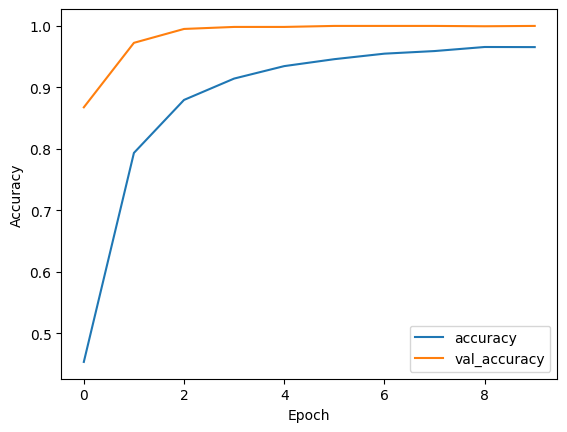

In [55]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3. Hậu xử lý

In [66]:
import tensorflow as tf
import joblib
import json

In [67]:
# Lưu mô hình dưới dạng JSON
model_json = model.to_json()  # Chuyển đổi mô hình thành định dạng JSON
with open('sign_language_model.json', 'w') as json_file:
    json.dump(model_json, json_file)  # Lưu vào file JSON

In [68]:
# Lưu mô hình và trọng số
model.save('sign_language_model.h5')  # Lưu mô hình vào file .h5

In [69]:
# Lưu trọng số của mô hình vào file .pkl
weights = model.get_weights()  # Lấy trọng số của mô hình
joblib.dump(weights, 'sign_language_weights.pkl')

['sign_language_weights.pkl']

In [70]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Lấy lớp có xác suất cao nhất

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_test, predicted_classes)
print(confusion_mtx)

report = classification_report(y_test, predicted_classes)
print(report)

[[221   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 180   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 213   0   0   0   0   0   0   0   0   0   0   7   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 221   2   0   0   0   7   0   5   1   0   0   0   0   0  19
    0   0   0   0   1   0]
 [  1   0   0   0 199   0   0   0   0   0   0   2   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1   0   0   0   0 241   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 188   9   0   0   0   0   0   0   0   0   0   0
   23   0   0   0   1   0]
 [  0   0   0   0   0   0  28 173   0   0   0   0   0   0   4   0   0   0
    0   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0 210   0   0   0   0   0   0   0   0   4
    0   0   0   0   0   0]
 [  0   0   0  14   0   2   0   0   1 144   0   0   0   0   0   0  54   0
    0   0   1   3

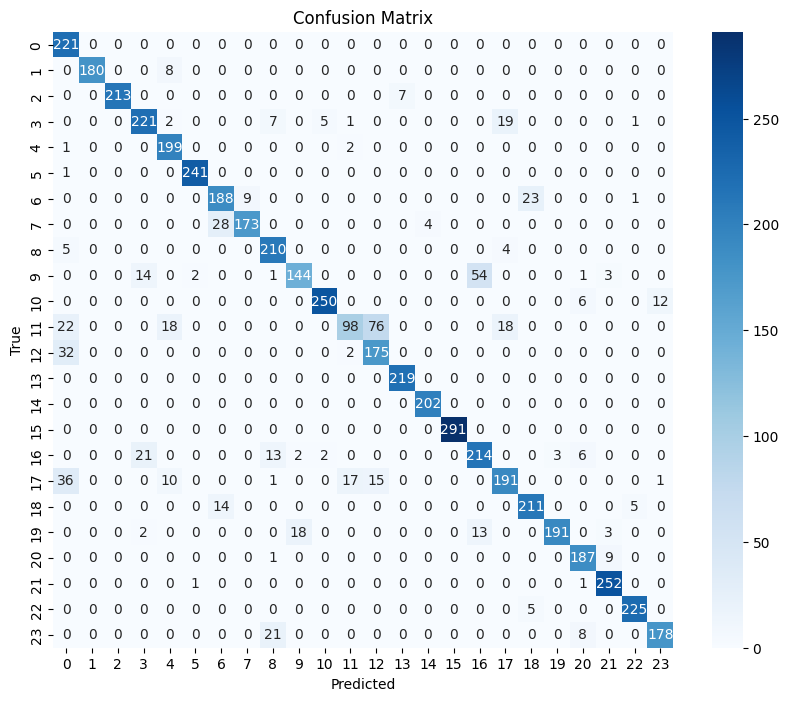

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()